In [1]:
import scniche as sn
import scanpy as sc
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/scniche_v101/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.1.0


In [2]:
# download data from figshare (https://figshare.com/ndownloader/files/50249673)
# adata = sn.datasets.human_dlpfc_visium()
adata = sc.read('DLPFC_donor3.h5ad')
adata

AnnData object with n_obs × n_vars = 14243 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'domain', 'slice'
    uns: 'CN_order'
    obsm: 'X_C2L', 'X_scVI', 'spatial'

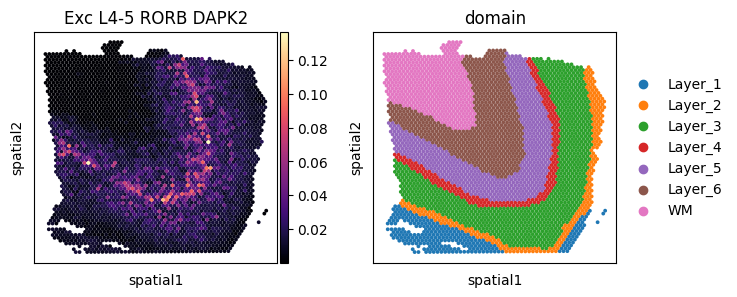

In [3]:
# choose slice151673 and show Cell2location deconvolution results
adata = adata[adata.obs['slice'] == 'slice151673']

decon_res = pd.DataFrame(adata.obsm['X_C2L'].copy())
decon_res.columns = adata.uns['CN_order']

show_celltype = 'Exc L4-5 RORB DAPK2'
adata.obs[show_celltype] = decon_res[show_celltype].values

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color=[show_celltype, 'domain', ], s=30, cmap='magma')

In [4]:
cutoff = 6
lr = 0.01
epochs = 100

# prepare
use_rep = 'X_scVI'
adata = sn.pp.cal_spatial_exp(adata=adata, mode='KNN', k_cutoff=cutoff, is_pca=False, verbose=False, layer_key=use_rep)


# only choose the features of the two views `X_data` and `X_data_nbr` to run scNiche
choose_views = ['X_data', 'X_data_nbr']
adata = sn.pp.prepare_data(adata=adata, verbose=False, choose_views=choose_views)
                
# training
model = sn.tr.Runner(adata=adata, device='cuda:0', verbose=False, choose_views=choose_views)
adata = model.fit(lr=lr, epochs=epochs)
                
# clustering
target_num = len(set(adata.obs['domain']))
adata = sn.tr.clustering(adata=adata, target_k=target_num)

Train Epoch: 100: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s, loss=14.9287]


Applying K-Means Clustering with 7 target cluster numbers...


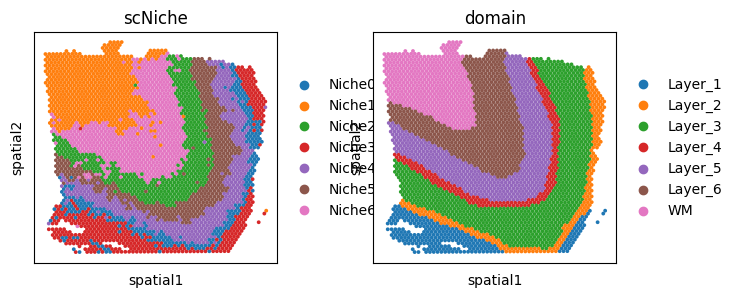

In [5]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color=['scNiche', 'domain'],s=30, )

In [6]:
adjusted_rand_score(adata.obs['domain'], adata.obs['scNiche'])

0.5282390229245433